# MLND CAPSTONE PROJECT

**Project Summary:**  

In this project, we will train a model that can decode sequences of digits from natural images, and create an app that prints the numbers it sees in real time using Tensorflow library.

The data that we will be using is Street View House Numbers (SVHN), a large-scale dataset of house numbers in Google Street View images.

## Download matlab data

In [1]:
# Import required modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf

from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

%matplotlib inline

In [2]:
# Download SVHN data from Stanford University repo
from urllib import urlretrieve
    
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  print('Found and downloaded', filename)
  return filename

In [3]:
# Download train, test and extra 32_32 matlab files for cropped digits
train_filename = maybe_download('train_32x32.mat')
test_filename = maybe_download('test_32x32.mat')
extra_filename = maybe_download('extra_32x32.mat')

Found and downloaded train_32x32.mat
Found and downloaded test_32x32.mat
Found and downloaded extra_32x32.mat


In [4]:
# Load matlab files using scipy.io library
import scipy.io as sio

train_data = sio.loadmat('train_32x32.mat', variable_names='X').get('X')
train_labels = sio.loadmat('train_32x32.mat', variable_names='y').get('y')
test_data = sio.loadmat('test_32x32.mat', variable_names='X').get('X')
test_labels = sio.loadmat('test_32x32.mat', variable_names='y').get('y')
# extra_data = sio.loadmat('extra_32x32.mat', variable_names='X').get('X')
# extra_labels = sio.loadmat('extra_32x32.mat', variable_names='y').get('y')

print("train data: ", train_data.shape, train_labels.shape)
print("test data: ", test_data.shape, test_labels.shape)
# print("extra data: ", extra_data.shape, extra_labels.shape)

train data:  (32, 32, 3, 73257) (73257, 1)
test data:  (32, 32, 3, 26032) (26032, 1)


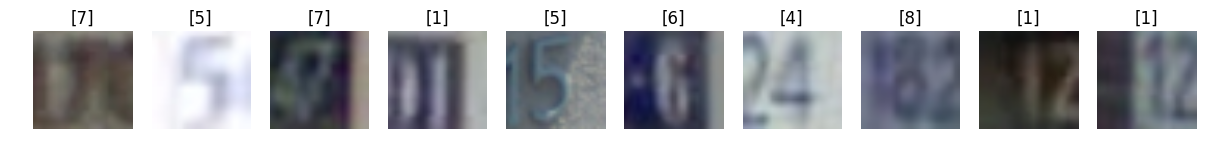

In [5]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_data[:,:,:,j])

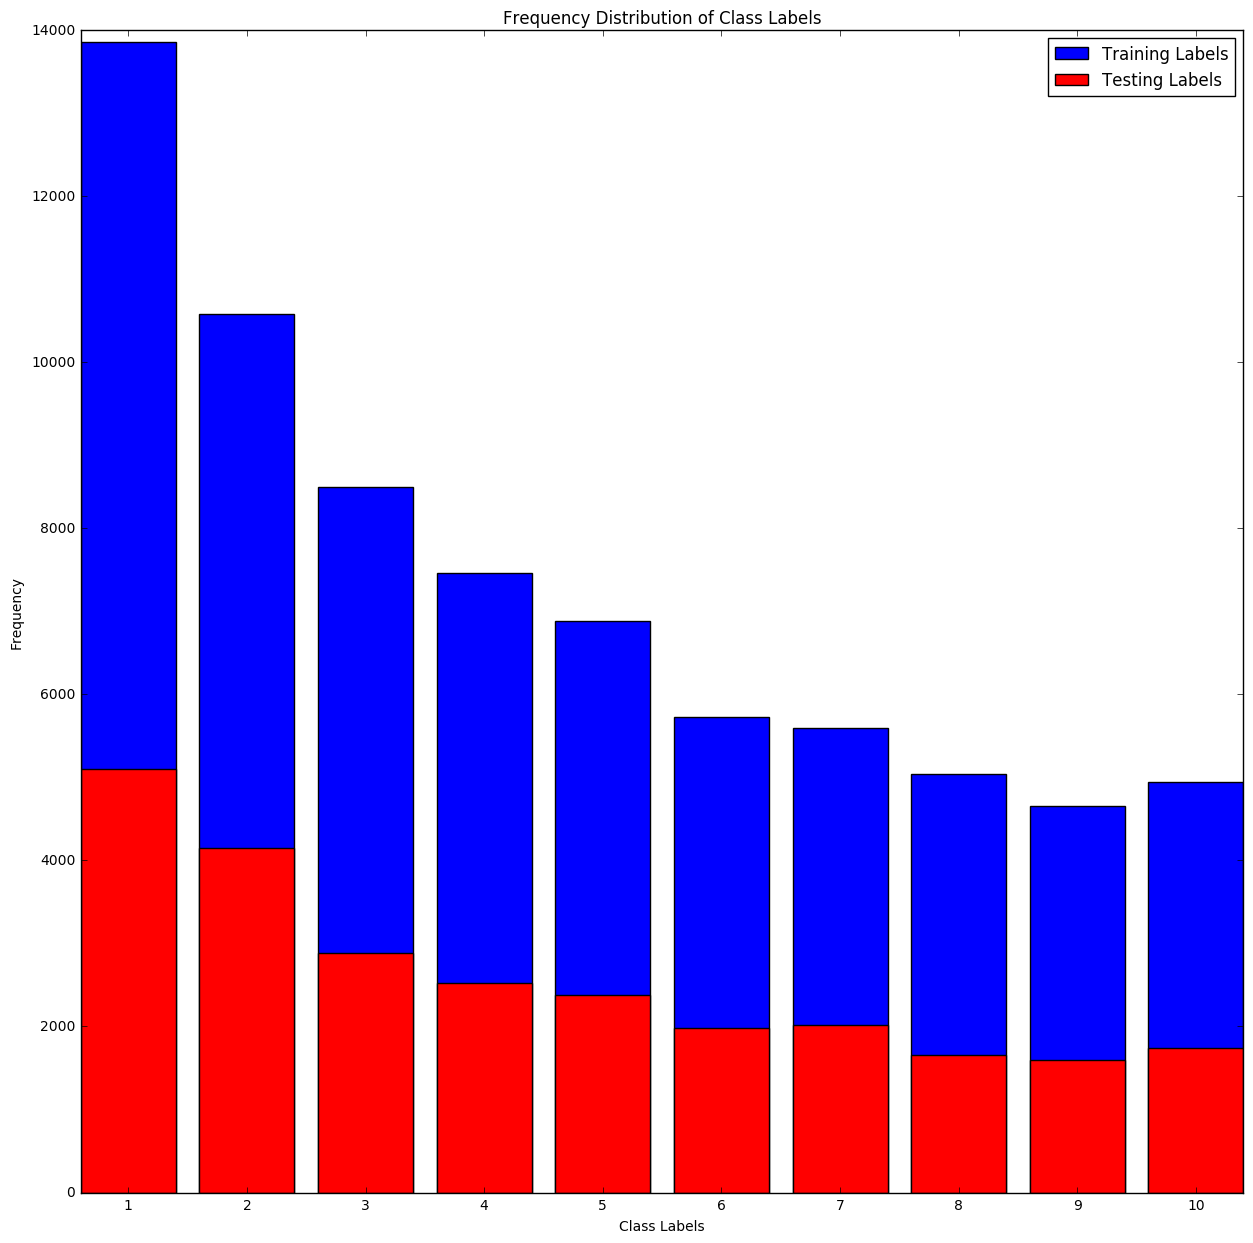

In [15]:
from collections import Counter

temp_labels = train_labels.reshape(73257).tolist()
temp_labels = dict(Counter(temp_labels))
plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', label='Training Labels')
plt.xticks(range(len(temp_labels)), temp_labels.keys())
temp_labels = test_labels.reshape(26032).tolist()
temp_labels = dict(Counter(temp_labels))
plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', color='red', label='Testing Labels')
plt.legend()
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Class Labels')
plt.show()

## Pre-processing Data

In [6]:
# first we will normalize image data in range of -1 and 1.
train_data = train_data.astype('float32') / 128.0 - 1
test_data = test_data.astype('float32') / 128.0 - 1

# reshaping np array so that we can access data in CNN friendly format i.e. [i,:,:,:] from [:,:,:,i]
train_data = np.transpose(train_data, (3, 0, 1, 2))
test_data = np.transpose(test_data,(3, 0, 1, 2))

#chaning class labels range 1-10 to 0-9
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

# processing labels in CNN friendly format i.e. 1-hot-encoding
num_labels = 10
train_labels = train_labels[:,0]
test_labels = test_labels[:,0]
train_labels = (np.arange(num_labels) == train_labels[:, None]).astype(np.float32)
test_labels = (np.arange(num_labels) == test_labels[:, None]).astype(np.float32)

print("train data: ", train_data.shape, train_labels.shape)
print("test data: ", test_data.shape, test_labels.shape)
print("sample one-hot encoding train label: ", train_labels[3])

train data:  (73257, 32, 32, 3) (73257, 10)
test data:  (26032, 32, 32, 3) (26032, 10)
sample one-hot encoding train label:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


In [7]:
# Create Validation data from Train data
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, 
                                                                      test_size=0.1, random_state=42)

print("train data: ", train_data.shape, train_labels.shape)
print("valid data: ", valid_data.shape, valid_labels.shape)

train data:  (65931, 32, 32, 3) (65931, 10)
valid data:  (7326, 32, 32, 3) (7326, 10)


In [8]:
# shuffle dataset
from sklearn.utils import shuffle

train_data, train_labels = shuffle(train_data, train_labels, random_state=0)
test_data, test_labels = shuffle(test_data, test_labels, random_state=0)

print("train data: ", train_data.shape, train_labels.shape)
print("test data: ", test_data.shape, test_labels.shape)
print("valid data: ", valid_data.shape, valid_labels.shape)

train data:  (65931, 32, 32, 3) (65931, 10)
test data:  (26032, 32, 32, 3) (26032, 10)
valid data:  (7326, 32, 32, 3) (7326, 10)


## Save to pickle file

In [10]:
# Create pickle file to save processed data
pickle_file = 'SVHN_single.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_data': train_data,
    'train_labels': train_labels,
    'test_data': test_data,
    'test_labels': test_labels
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1133720175
